<a href="https://colab.research.google.com/github/TaruSora/NLP_100knock/blob/main/100knock_9_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip
!sed -e 's/"/'\''/g' newsCorpora.csv > newsCorpora_re.csv

--2022-04-01 04:41:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  13.2MB/s    in 2.1s    

2022-04-01 04:41:34 (13.2 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
# 50のコードをそのまま利用

import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

train, tmp = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['CATEGORY'])
valid, test = train_test_split(tmp, test_size=0.5, shuffle=True, random_state=42, stratify=tmp['CATEGORY'])

train.to_csv('train.txt', sep='\t', index=False)
valid.to_csv('valid.txt', sep='\t', index=False)
test.to_csv('test.txt', sep='\t', index=False)

print('学習用データ')
print(train['CATEGORY'].value_counts())
print('評価用データ')
print(valid['CATEGORY'].value_counts())
print('テスト用データ')
print(test['CATEGORY'].value_counts())

学習用データ
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
評価用データ
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
テスト用データ
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [ ]:
# 85までのコードを利用

from collections import defaultdict
import string

dir = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
for text in train['TITLE']:
    for word in text.translate(table).split():
        dir[word] += 1
dir = sorted(dir.items(), key=lambda x:x[1], reverse=True)

# ２回以上出現した単語を登録
word2id = {word: i+1 for i, (word, count) in enumerate(dir) if count > 1}

print(word2id)

{'to': 1, 's': 2, 'in': 3, 'UPDATE': 4, 'on': 5, 'as': 6, 'US': 7, 'The': 8, 'of': 9, 'for': 10, '1': 11, 'To': 12, '2': 13, 'the': 14, 'and': 15, 'In': 16, 'Of': 17, 'at': 18, 'a': 19, 'A': 20, 'With': 21, 'Is': 22, 'For': 23, 'And': 24, 'with': 25, 'after': 26, 'New': 27, '3': 28, 'Kardashian': 29, 'China': 30, 'up': 31, 'On': 32, 'Kim': 33, 'by': 34, 'After': 35, 'says': 36, 'is': 37, 'At': 38, 'ECB': 39, 'STOCKS': 40, 'Fed': 41, 't': 42, 'From': 43, '4': 44, 'new': 45, 'from': 46, 'her': 47, 'It': 48, 'Wall': 49, 'Says': 50, 'Miley': 51, 'Cyrus': 52, 'FOREX': 53, 'shares': 54, 'First': 55, '5': 56, 'Dollar': 57, 'data': 58, 'CEO': 59, 'over': 60, 'About': 61, 'Google': 62, 'West': 63, 'St': 64, 'she': 65, 'May': 66, 'You': 67, 'S': 68, 'Euro': 69, 'Ukraine': 70, 'Over': 71, 'bln': 72, 'Up': 73, 'Will': 74, 'More': 75, 'Chris': 76, 'As': 77, 'Be': 78, 'Kanye': 79, 'Justin': 80, 'Star': 81, 'Stocks': 82, 'Bieber': 83, '2014': 84, 'off': 85, 'be': 86, 'euro': 87, 'Billion': 88, 'UK': 

In [ ]:
# 単語列をIDに変換する関数
def tokenizer(text, word2id=word2id, unk=0):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    return [word2id.get(word, unk) for word in text.translate(table).split()]

In [ ]:
# データセットの作成
import torch
from torch.utils.data import Dataset

class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):  
        return len(self.y)

    def __getitem__(self, index):  
        text = self.X[index]
        inputs = self.tokenizer(text)

        return {
           'inputs': torch.tensor(inputs, dtype=torch.int64),
           'labels': torch.tensor(self.y[index], dtype=torch.int64)
        }  

In [ ]:
label2id = {"b": 0, "t": 1, "e": 2, "m": 3}

train = pd.read_table("train.txt")
valid = pd.read_table("valid.txt")
test = pd.read_table("test.txt")

y_train = train['CATEGORY'].map(lambda x: label2id[x]).values
y_valid = valid['CATEGORY'].map(lambda x: label2id[x]).values
y_test = test['CATEGORY'].map(lambda x: label2id[x]).values

train_dataset = CreateDataset(train['TITLE'], y_train, tokenizer)
valid_dataset = CreateDataset(valid['TITLE'], y_valid, tokenizer)
test_dataset = CreateDataset(test['TITLE'], y_test, tokenizer)

In [ ]:
FILE_ID = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
FILE_NAME = "GoogleNews-vectors-negative300.bin.gz"
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt

--2022-04-01 04:41:38--  https://docs.google.com/uc?export=download&confirm=t&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Resolving docs.google.com (docs.google.com)... 74.125.204.138, 74.125.204.100, 74.125.204.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.204.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/q0vjqgem1jgjds9sj75161kvm9i9v99a/1648788075000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download [following]
--2022-04-01 04:41:38--  https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/q0vjqgem1jgjds9sj75161kvm9i9v99a/1648788075000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download
Resolving doc-0g-8s-docs.googleusercontent.com (doc-0g-8s-docs.googleusercontent.com)... 142.250.157.132, 2404:6800:4008:c13::84
Connecting to doc-0g-8s-docs.googleusercontent.com (doc-0g-8s-docs.googleus

In [ ]:
# 学習済みモデルのロード
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

In [ ]:
import numpy as np

# 学習済み単語ベクトルの取得
vocab_size = len(set(word2id.values())) + 1
emb_size = 300
weights = np.zeros((vocab_size, emb_size))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = model[word]
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(emb_size,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {vocab_size}')
print(weights.size())

学習済みベクトル利用単語数: 9130 / 9375
torch.Size([9375, 300])


86.ID番号で表現された単語列x=(x1,x2,…,xT)がある．ただし，Tは単語列の長さ，xt∈RVは単語のID番号のone-hot表記である（Vは単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列xからカテゴリyを予測するモデルを実装せよ．

In [ ]:
import torch.nn as nn
from torch.nn import functional as F

class MyCNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
        super().__init__()
        if emb_weights is None:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(out_channels, output_size)

    def forward(self, x):
        emb = self.emb(x).unsqueeze(1)
        conv = self.conv(emb)
        act = F.relu(conv.squeeze(3))
        max_pool = F.max_pool1d(act, act.size()[2])
        out = self.fc(max_pool.squeeze(2))
        return out

vocab_size = len(set(word2id.values())) + 1
emb_size = 300
output_size = 4
padding_idx = len(set(word2id.values()))
out_channels = 100
kernel_heights = 3
stride = 1
padding = 1

net = MyCNN(vocab_size, emb_size, output_size, padding_idx, out_channels, kernel_heights, stride, padding, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
    X = train_dataset[i]['inputs']
    print(torch.softmax(net(X.unsqueeze(0)), dim=-1))

tensor([[9.4955e-05, 9.5218e-05, 1.2578e-04,  ..., 1.0595e-04, 1.3034e-04,
         9.8875e-05]], grad_fn=<SoftmaxBackward0>)
tensor([[9.7206e-05, 1.0056e-04, 1.3306e-04,  ..., 1.0973e-04, 1.3205e-04,
         1.0038e-04]], grad_fn=<SoftmaxBackward0>)
tensor([[8.6121e-05, 1.0234e-04, 1.3926e-04,  ..., 1.0658e-04, 1.4626e-04,
         9.8800e-05]], grad_fn=<SoftmaxBackward0>)
tensor([[9.2944e-05, 9.8892e-05, 1.2634e-04,  ..., 1.1421e-04, 1.3233e-04,
         9.8049e-05]], grad_fn=<SoftmaxBackward0>)
tensor([[8.4992e-05, 9.6880e-05, 1.2854e-04,  ..., 1.0933e-04, 1.3131e-04,
         8.9879e-05]], grad_fn=<SoftmaxBackward0>)
tensor([[9.2926e-05, 1.0039e-04, 1.4146e-04,  ..., 1.0938e-04, 1.3469e-04,
         9.6725e-05]], grad_fn=<SoftmaxBackward0>)
tensor([[9.0704e-05, 1.0158e-04, 1.2540e-04,  ..., 1.0744e-04, 1.2879e-04,
         9.8274e-05]], grad_fn=<SoftmaxBackward0>)
tensor([[9.4993e-05, 1.0109e-04, 1.2467e-04,  ..., 1.1189e-04, 1.4472e-04,
         9.4238e-05]], grad_fn=<SoftmaxBack

87.確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ.

In [ ]:
import time
from torch.utils.data import DataLoader
from torch import optim

# 78の関数を改変
def calc_loss_acc(model, device, dataset, criterion=None):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            x = data['inputs'].to(device)
            t = data['labels'].to(device)
            y = model(x) 

            if criterion != None:
                loss += criterion(y, t).item()

            pred = torch.argmax(y, dim=-1)
            total += len(x)
            correct += (pred == t).sum().item()

    return loss / len(dataloader), correct / total 

# 78の関数を改変
def model_function(train_dataset, valid_dataset, batch_size, device, model, criterion, optimizer, max_epoch, collate_fn=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, max_epoch, eta_min=1e-5, last_epoch=-1)

    train_log = []
    valid_log = []
    
    for epoch in range(max_epoch):
        start = time.time()

        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            x = data['inputs'].to(device)
            t = data['labels'].to(device)
            y = model(x)
            loss = criterion(y, t)        
            loss.backward()
            optimizer.step()

        model.eval()

        train_loss, train_acc = calc_loss_acc(model, device, train_dataset, criterion)
        valid_loss, valid_acc = calc_loss_acc(model, device, valid_dataset, criterion)
        train_log.append([train_loss, train_acc])
        valid_log.append([valid_loss, valid_acc])   

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
        
        end = time.time() 
        print(f'epoch: {epoch + 1}, loss_train: {train_loss:.4f}, accuracy_train: {train_acc:.4f}, loss_valid: {valid_loss:.4f}, accuracy_valid: {valid_acc:.4f}, {(end - start):.4f}sec') 

        if epoch > 2 and valid_log[epoch - 3][0] <= valid_log[epoch - 2][0] <= valid_log[epoch - 1][0] <= valid_log[epoch][0]:
            break  
        scheduler.step()
    return {'train': train_log, 'valid': valid_log}

In [ ]:
import matplotlib.pyplot as plt

# グラフ表示するための関数
def logs(log):
    figure, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.show()

In [ ]:
# 複数の文の最大系列長に合わせてパディングする
class Padsequence():
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx

    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)   
        sequences = [x['inputs'] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
        labels = torch.LongTensor([x['labels'] for x in sorted_batch])

        return {'inputs': sequences_padded, 'labels': labels}

epoch: 1, loss_train: 0.8770, accuracy_train: 0.6819, loss_valid: 0.9452, accuracy_valid: 0.6400, 13.0321sec
epoch: 2, loss_train: 0.6607, accuracy_train: 0.7691, loss_valid: 0.8450, accuracy_valid: 0.6879, 11.1598sec
epoch: 3, loss_train: 0.5863, accuracy_train: 0.8087, loss_valid: 0.8968, accuracy_valid: 0.6707, 11.0686sec
epoch: 4, loss_train: 0.4107, accuracy_train: 0.8756, loss_valid: 0.7147, accuracy_valid: 0.7373, 11.4569sec
epoch: 5, loss_train: 0.3220, accuracy_train: 0.9075, loss_valid: 0.6810, accuracy_valid: 0.7522, 11.8712sec
epoch: 6, loss_train: 0.2525, accuracy_train: 0.9297, loss_valid: 0.6312, accuracy_valid: 0.7672, 11.3996sec
epoch: 7, loss_train: 0.2158, accuracy_train: 0.9431, loss_valid: 0.6099, accuracy_valid: 0.7852, 11.1440sec
epoch: 8, loss_train: 0.1963, accuracy_train: 0.9571, loss_valid: 0.6104, accuracy_valid: 0.7814, 11.4465sec
epoch: 9, loss_train: 0.1886, accuracy_train: 0.9606, loss_valid: 0.6084, accuracy_valid: 0.7822, 11.5058sec
epoch: 10, loss_tra

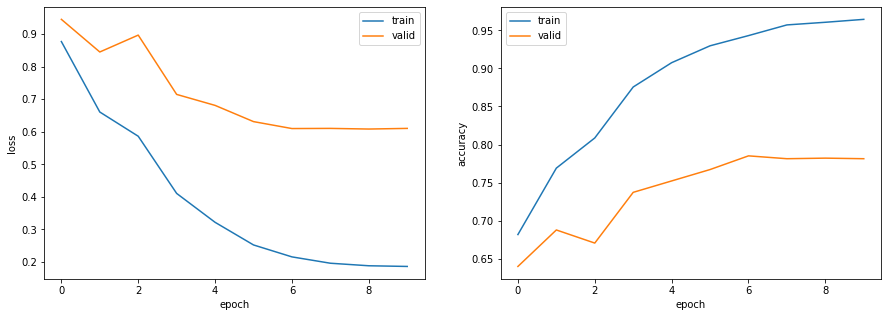

正解率（学習データ）：0.964
正解率（評価データ）：0.814


In [ ]:
# 87 確率的勾配降下法によるCNNの学習

vocab_size = len(set(word2id.values())) + 1
emb_size = 300
output_size = 4
padding_idx = len(set(word2id.values()))
out_channels = 100
kernel_heights = 3
stride = 1
padding = 1
lr = 0.1
batch_size = 32
max_epochs = 10

model2 = MyCNN(vocab_size, emb_size, output_size, padding_idx, out_channels, kernel_heights, stride, padding, emb_weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=lr)
device = torch.device('cuda:0')
model2 = model2.to(device)

log = model_function(train_dataset, valid_dataset, batch_size, device, model2, criterion, optimizer, max_epochs, collate_fn=Padsequence(padding_idx))

# グラフ表示
logs(log)

_, train_acc = calc_loss_acc(model2, device, train_dataset)
_, test_acc = calc_loss_acc(model2, device, test_dataset)
print(f'正解率（学習データ）：{train_acc:.3f}')
print(f'正解率（評価データ）：{test_acc:.3f}')